In [1]:
import zipfile
import os

zip_path = "data/store-sales-time-series-forecasting.zip" 
extract_path = "data"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)


In [2]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
stores = pd.read_csv("data/stores.csv")
transactions = pd.read_csv("data/transactions.csv")
holidays = pd.read_csv("data/holidays_events.csv")  
oil = pd.read_csv("data/oil.csv")
sample_sub = pd.read_csv("data/sample_submission.csv")

print(train.head())


   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


In [3]:
print(train.shape)
print(train.info())
print(train.describe())
print(train.isna().sum())

(3000888, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02
id             0
date           0
store_

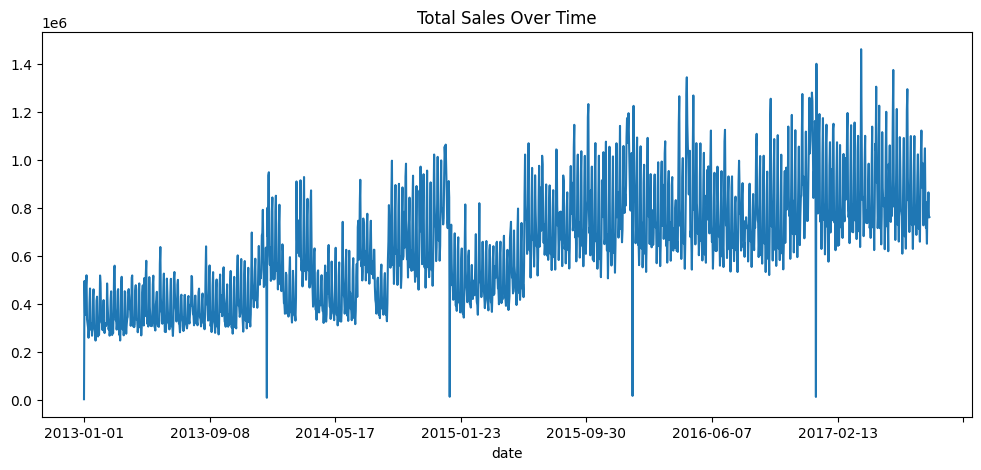

In [4]:
import matplotlib.pyplot as plt

train.groupby("date")["sales"].sum().plot(figsize=(12,5), title="Total Sales Over Time")
plt.show()


الأيام اللي فيها انخفاض غير طبيعي:
date
2013-01-01     2511.618999
2014-01-01     8602.065404
2015-01-01    12773.616980
2016-01-01    16433.394000
2017-01-01    12082.500997
Name: sales, dtype: float64


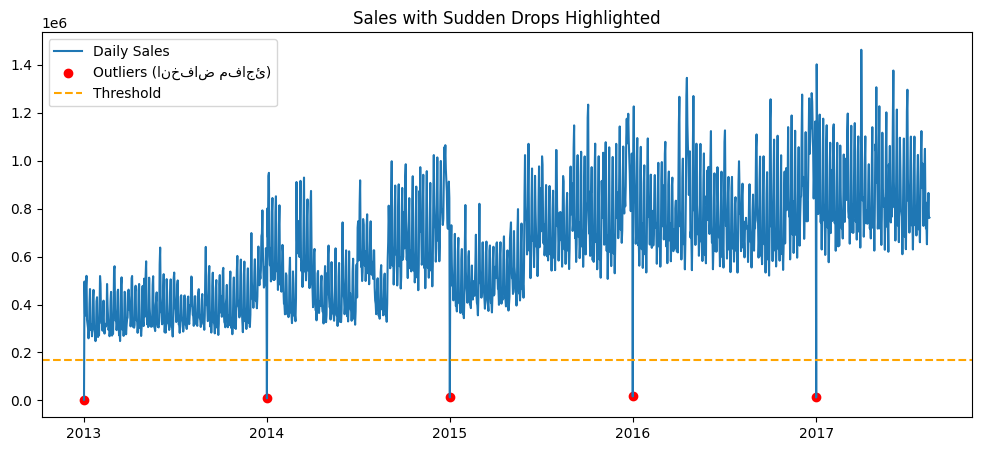

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

daily_sales = train.groupby("date")["sales"].sum()

mean = daily_sales.mean()
std = daily_sales.std()

threshold = mean - 2*std
outliers = daily_sales[daily_sales < threshold]

print("outliers")
print(outliers)

plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values, label="Daily Sales")
plt.scatter(outliers.index, outliers.values, color="red", label="Outliers")
plt.axhline(threshold, color="orange", linestyle="--", label="Threshold")
plt.title("Sales with Sudden Drops Highlighted")
plt.legend()
plt.show()

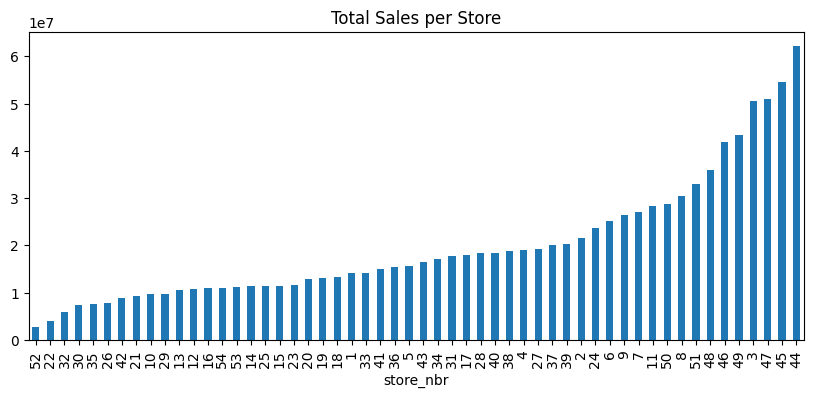

In [5]:
store_sales = train.groupby("store_nbr")["sales"].sum().sort_values()
store_sales.plot(kind="bar", figsize=(10,4), title="Total Sales per Store")
plt.show()


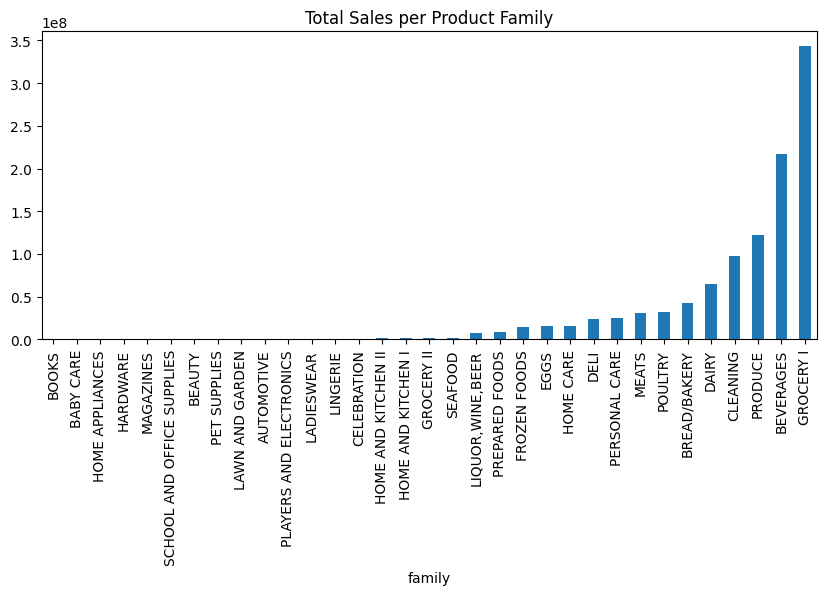

In [6]:
family_sales = train.groupby("family")["sales"].sum().sort_values()
family_sales.plot(kind="bar", figsize=(10,4), title="Total Sales per Product Family")
plt.show()


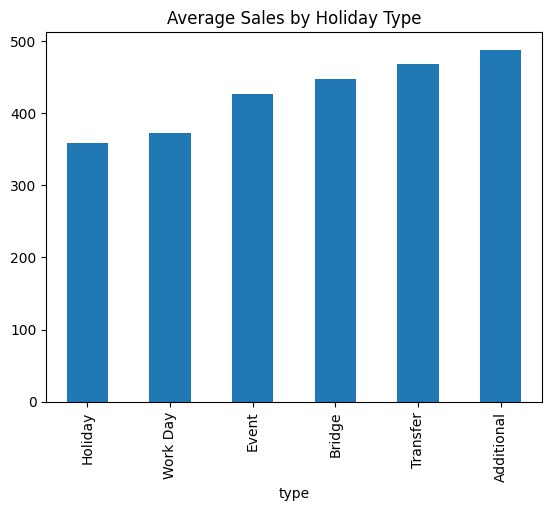

In [7]:
holidays['date'] = pd.to_datetime(holidays['date'])
train['date'] = pd.to_datetime(train['date'])

merged = train.merge(holidays[['date', 'type']], on='date', how='left')
merged.groupby('type')['sales'].mean().sort_values().plot(kind='bar', title='Average Sales by Holiday Type')
plt.show()


In [6]:
import pandas as pd
train['date'] = pd.to_datetime(train['date'], errors='coerce')
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
oil['date'] = pd.to_datetime(oil['date'], errors='coerce')

merged_tx = train.merge(transactions, on=["date", "store_nbr"], how="left")
merged_oil = train.merge(oil, on="date", how="left")

print(merged_tx["sales"].corr(merged_tx["transactions"]))
print(merged_oil["sales"].corr(merged_oil["dcoilwtico"]))


0.21481484042443258
-0.07905016021992588


In [ ]:

import os
import zipfile
from pathlib import Path
from typing import List, Optional, Tuple, Dict
import glob
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
import category_encoders as ce
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

ZIP_PATH = "data/store-sales-time-series-forecasting.zip"
EXTRACT_DIR = "data"
OUT_DIR = Path("models")
OUT_DIR.mkdir(parents=True, exist_ok=True)
DIAG_DIR = OUT_DIR / "diag"
DIAG_DIR.mkdir(parents=True, exist_ok=True)

xgb_params = dict(
    objective='reg:squarederror',
    learning_rate=0.02,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=1.0,
    tree_method='gpu_hist',
    eval_metric='rmse',
    seed=42,
    verbosity=1 )

N_SPLITS = 5
DEFAULT_NUM_BOOST_ROUND = 4200
EARLY_STOPPING_ROUNDS = 110
RANDOM_STATE = 42

def target_transform(x):
    x = np.array(x, dtype=float)
    return np.log1p(x)

def inv_target_transform(x):
    x = np.array(x, dtype=float)
    return np.expm1(x)

def ensure_sorted(df: pd.DataFrame, by: List[str]) -> pd.DataFrame:
    return df.sort_values(by).reset_index(drop=True)

def safe_metrics(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nonzero = y_true != 0
    mape = (np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])).mean() * 100 if nonzero.sum() > 0 else np.nan
    try:
        r2 = r2_score(y_true, y_pred)
    except Exception:
        r2 = np.nan
    return dict(MAE=float(mae), RMSE=float(rmse), MAPE=float(mape), R2=float(r2))

def rmsle_from_sales(y_true, y_pred):
    y_true = np.clip(np.array(y_true, dtype=float), 0, None)
    y_pred = np.clip(np.array(y_pred, dtype=float), 0, None)
    return float(np.sqrt(mean_squared_log_error(y_true, y_pred)))

def build_frame(df: pd.DataFrame, stores: Optional[pd.DataFrame], transactions: Optional[pd.DataFrame], oil: Optional[pd.DataFrame], holidays: Optional[pd.DataFrame]) -> pd.DataFrame:
    g = df.copy()
    if 'date' in g.columns:
        g['date'] = pd.to_datetime(g['date'])
    if {'store_nbr','family','date'}.issubset(g.columns):
        g = ensure_sorted(g, ['store_nbr','family','date'])

    if 'store_nbr' in g.columns and stores is not None:
        g = g.merge(stores, on='store_nbr', how='left')

    if transactions is not None and {'date','store_nbr'}.issubset(transactions.columns):
        tx = transactions.copy()
        tx['date'] = pd.to_datetime(tx['date'])
        g = g.merge(tx, on=['date','store_nbr'], how='left')

    if oil is not None:
        oil_local = oil.copy()
        if 'dcoilwtico' in oil_local.columns:
            oil_local = oil_local.rename(columns={'dcoilwtico':'oil_price'})
        if 'date' in oil_local.columns:
            oil_local['date'] = pd.to_datetime(oil_local['date'])
            g = g.merge(oil_local, on='date', how='left')

    if holidays is not None:
        h = holidays.copy()
        h['date'] = pd.to_datetime(h['date'])
        h['type'] = h['type'].astype(str).str.strip().str.lower()
        h['is_transfer'] = (h['type']=='transfer').astype(int)
        h['is_bridge'] = (h['type']=='bridge').astype(int)
        h['is_work_day'] = h['type'].str.contains('work', na=False).astype(int)
        h['is_event'] = (h['type']=='event').astype(int)
        h['is_holiday'] = h['type'].isin(['holiday','additional']).astype(int)
        if 'transferred' in h.columns:
            h.loc[h['transferred'], 'is_holiday'] = 0
            h.loc[h['is_transfer']==1, 'is_holiday'] = 1
        hol_daily = (h.groupby('date').agg({'is_holiday':'max','is_bridge':'max','is_work_day':'max'}).reset_index())
        for c in ['is_holiday','is_bridge','is_work_day']:
            hol_daily[c] = hol_daily[c].fillna(0).astype(int)
        g = g.merge(hol_daily, on='date', how='left')
        for c in ['is_holiday','is_bridge','is_work_day']:
            g[c] = g[c].fillna(0).astype(int)

    if 'date' in g.columns:
        g['dow'] = g['date'].dt.dayofweek
        g['dom'] = g['date'].dt.day
        g['week'] = g['date'].dt.isocalendar().week.astype(int)
        g['month'] = g['date'].dt.month
        g['year'] = g['date'].dt.year
        g['is_weekend'] = (g['dow'] >= 5).astype(int)
        g['is_month_end'] = g['date'].dt.is_month_end.astype(int)
        g['is_month_start'] = g['date'].dt.is_month_start.astype(int)
        g['quarter'] = g['date'].dt.quarter
        g['dayofyear'] = g['date'].dt.dayofyear

    if 'transactions' in g.columns:
        g['transactions'] = g['transactions'].fillna(0)
    if 'onpromotion' in g.columns:
        g['onpromotion'] = g['onpromotion'].fillna(0)

    if 'date' in g.columns:
        def prev_payday(d):
            if d.day >= 15:
                return d.replace(day=15)
            return d.replace(day=1)
        def next_payday(d):
            if d.day <= 15:
                return d.replace(day=15)
            return (d + pd.offsets.MonthBegin(1)).replace(day=1)
        g['prev_payday_date'] = g['date'].apply(prev_payday)
        g['next_payday_date'] = g['date'].apply(next_payday)
        g['days_from_prev_payday'] = (g['date'] - g['prev_payday_date']).dt.days
        g['days_to_next_payday'] = (g['next_payday_date'] - g['date']).dt.days
        g['days_to_nearest_payday'] = np.minimum(g['days_from_prev_payday'].fillna(9999), g['days_to_next_payday'].fillna(9999))
        g['is_payday'] = ((g['dom'] == 15) | (g['dom'] == 1)).astype(int)
        g['pay_window_3'] = (g['days_to_nearest_payday'] <= 5).astype(int)

    if 'date' in g.columns:
        event_date = np.datetime64('2016-04-16','D')
        g['days_since_earthquake'] = (g['date'].values.astype('datetime64[D]') - event_date).astype('timedelta64[D]').astype(int)
        g['after_earthquake_28'] = ((g['days_since_earthquake'] >= 0) & (g['days_since_earthquake'] <= 30)).astype(int)
        g['earthquake_decay'] = np.exp(-np.clip(g['days_since_earthquake'],0,None)/7.0)
        g.loc[g['days_since_earthquake'] < 0, 'earthquake_decay'] = 0.0

    if 'store_nbr' in g.columns and 'family' in g.columns:
        g['_grp_key'] = g['store_nbr'].astype(str) + '__' + g['family'].astype(str)
        g['store_family'] = g['store_nbr'].astype(str) + '_' + g['family'].astype(str)
    g = g.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

    if 'sales' in g.columns:
        g['sales_log'] = target_transform(g['sales'])
        if {'store_nbr','family','date'}.issubset(g.columns):
            grp = ['store_nbr','family']
            date_where_nonzero = g['date'].where(g['sales'] > 0)
            g['last_nonzero_date'] = date_where_nonzero.groupby(g['_grp_key']).ffill()
            g['days_since_last_nonzero'] = (g['date'] - g['last_nonzero_date']).dt.days
            g.loc[g['sales'] > 0, 'days_since_last_nonzero'] = 0
            g['days_since_last_nonzero'] = g['days_since_last_nonzero'].fillna(999).astype(int)
            g['count_nonzero_last_28'] = g.groupby(grp)['sales'].transform(lambda s: (s.shift(1) > 0).rolling(28, min_periods=1).sum()).astype(int)
            if 'transactions' in g.columns:
                g['count_txn_nonzero_last_28'] = g.groupby(grp)['transactions'].transform(lambda s: (s.shift(1) > 0).rolling(28, min_periods=1).sum()).astype(int)
            else:
                g['count_txn_nonzero_last_28'] = 0

            g['family_avg_sales'] = g.groupby('family')['sales_log'].transform(lambda s: s.shift(1).expanding().mean()).fillna(0.0)
            if 'transactions' in g.columns:
                g['family_avg_transactions'] = g.groupby('family')['transactions'].transform(lambda s: s.shift(1).expanding().mean()).fillna(0.0)
            else:
                g['family_avg_transactions'] = 0.0

            g = g.sort_values(['family', 'date']).reset_index(drop=True)
            g['family_cum_sales'] = g.groupby('family')['sales_log'].cumsum().shift(1).fillna(0.0)
            g['family_cum_count'] = g.groupby('family').cumcount()
            g['family_avg_past'] = (g['family_cum_sales'] / g['family_cum_count'].replace(0, np.nan)).fillna(0.0)
            g = g.sort_values('date').reset_index(drop=True)
            g['global_cum_sales'] = g['sales'].cumsum().shift(1).fillna(0.0)
            g['family_sales_ratio_past'] = np.where(g['global_cum_sales']>0, g['family_cum_sales']/g['global_cum_sales'], 0.0)

    g['payday_x_family_avg'] = g.get('is_payday',0) * g.get('family_avg_sales',0)
    g['pay_window3_x_family_avg'] = g.get('pay_window_3',0) * g.get('family_avg_sales',0)
    g['earthquake28_x_family_avg'] = g.get('after_earthquake_28',0) * g.get('family_avg_sales',0)
    g['earthquake_decay_x_family_avg'] = g.get('earthquake_decay',0) * g.get('family_avg_sales',0)

    if '_grp_key' in g.columns:
        g = g.drop(columns=['_grp_key'])
    return g

def promo_proximity(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    df['promo_date'] = df['date'].where(df.get('onpromotion',0) > 0)
    if {'store_nbr','family'}.issubset(df.columns):
        df['last_promo_date'] = df.groupby(['store_nbr','family'])['promo_date'].ffill()
        df['days_since_last_promo'] = (df['date'] - df['last_promo_date']).dt.days.fillna(999).astype(int)
        df['next_promo_date'] = df.groupby(['store_nbr','family'])['promo_date'].bfill()
        df['days_to_next_promo'] = (df['next_promo_date'] - df['date']).dt.days.fillna(999).astype(int)

    df = df.drop(columns=['promo_date','last_promo_date','next_promo_date'], errors='ignore')
    return df

def add_lags_rolls(df: pd.DataFrame, lags=(1,2,7,14,28), roll_windows=(7,14,28), promo_lags=(7,14,28), promo_rolls=(7,14,28)) -> pd.DataFrame:
    if {'store_nbr','family','date'}.issubset(df.columns):
        df = ensure_sorted(df, ['store_nbr','family','date'])
        grp = ['store_nbr','family']
    for lag in lags: 
        df[f'lag_{lag}'] = df.groupby(grp)['sales_log'].shift(lag)
    
    for w in roll_windows:
        df[f'rmean_{w}'] = df.groupby(grp)['sales_log'].transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=max(2, w//2)).mean())
        df[f'rmedian_{w}'] = df.groupby(grp)['sales_log'].transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=max(2, w//2)).median())
        df[f'rstd_{w}'] = df.groupby(grp)['sales_log'].transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=max(2, w//2)).std())

    df['rmean7_div_rmean14'] = df.get('rmean_7',0) / (df.get('rmean_14',0).replace(0, np.nan))
    df['lag7_minus_lag14'] = df.get('lag_7',0) - df.get('lag_14',0)
    df['lag7_pct_change'] = (df.get('lag_7',0) - df.get('lag_14',0)) / (df.get('lag_14',0) + 1e-9)
    df['rmean7_minus_lag7'] = df.get('rmean_7',0) - df.get('lag_7',0)

    for lag in promo_lags:
        df[f'promo_lag_{lag}'] = df.groupby(grp)['onpromotion'].shift(lag)
    for w in promo_rolls:
        df[f'promo_rmean_{w}'] = df.groupby(grp)['onpromotion'].transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=max(1,w//2)).mean())
        df[f'promo_rstd_{w}'] = df.groupby(grp)['onpromotion'].transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=max(1,w//2)).std())
   
    if 'transactions' in df.columns and 'onpromotion' in df.columns:
        df['promo_per_txn'] = (df['onpromotion'].astype(float) / df['transactions'].shift(1).replace(0, np.nan)).fillna(0)
   
    df['has_promo'] = (df.get('onpromotion',0) > 0).astype(int)

    for lag in lags:
        s = df.groupby(grp)['sales_log']
        df[f'diff_lag_{lag}'] = s.transform(lambda x, lag=lag: x - x.shift(lag))
        df[f'pct_change_lag_{lag}'] = s.transform(lambda x, lag=lag: (x - x.shift(lag)) / (x.shift(lag) + 1e-9))

    for w in (7,14,28):
        df[f'promo_count_{w}'] = df.groupby(grp)['onpromotion'].transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=1).sum()).fillna(0) if grp else 0

    for w in (7,14,28):
        df[f'tx_rmean_{w}'] = df.groupby('store_nbr')['transactions'].transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=1).mean())
   
    if 'oil_price' in df.columns:
        for w in (7,14,28):
            df[f'oil_rmean_{w}'] = df.groupby('store_nbr')['oil_price'].transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=1).mean())
   
    for w in (7,14,28):
        df[f'zero_count_{w}'] = df.groupby(grp)['sales_log'].transform(lambda s, w=w: (s.shift(1) == 0).rolling(w, min_periods=1).sum()) if grp else 0

    lags_ewm = [7,14,28]
    alphas = [0.9, 0.7]
    for lag in lags_ewm:
        for alpha in alphas:
            df[f'ewm_{lag}_alpha{alpha}'] = df.groupby(grp)['sales_log'].transform(lambda s, lag=lag, alpha=alpha: s.shift(lag).ewm(alpha=alpha).mean())
            df[f'ewmtrans_{lag}_alpha{alpha}'] = df.groupby(grp)['transactions'].transform(lambda s, lag=lag, alpha=alpha: s.shift(lag).ewm(alpha=alpha).mean()) if 'transactions' in df.columns else 0

            df[f'ewmoil_{lag}_alpha{alpha}'] = df.groupby('store_nbr')['oil_price'].transform(lambda s, lag=lag, alpha=alpha: s.shift(lag).ewm(alpha=alpha).mean())    
    return df

def add_spike_and_interaction_features(df: pd.DataFrame, group_keys=['store_nbr','family'], date_col='date', sales_col='sales_log', promo_col='onpromotion') -> pd.DataFrame:
    df = df.copy()
    eps = 1e-9
    df[date_col] = pd.to_datetime(df[date_col])
    if set(group_keys).issubset(df.columns):
        df = ensure_sorted(df, group_keys + [date_col])

    raw = sales_col
    for w in (7,14,28,56):
        if set(group_keys).issubset(df.columns):
            grp = df.groupby(group_keys)[raw]
            df[f'roll_max_{w}'] = grp.transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=1).max())
            df[f'roll_sum_{w}'] = grp.transform(lambda s, w=w: s.shift(1).rolling(w, min_periods=1).sum())

    for q in (0.90, 0.95, 0.99):
        col = f'group_q{int(q*100)}'
        if set(group_keys).issubset(df.columns):
            df[col] = df.groupby(group_keys)[raw].transform(lambda s, q=q: s.shift(1).rolling(56, min_periods=5).quantile(q)).fillna(0)

    df['dev_vs_q95'] = (df[raw].shift(1) - df['group_q95']) / (df['group_q95'].abs() + eps)
    df['dev_vs_rmean7'] = (df[raw].shift(1) - df.get('rmean_7',0)) / (np.abs(df.get('rmean_7',0)) + eps)
 
    df['flag_dev_q95_gt0'] = (df['dev_vs_q95'] > 0).astype(int)
    df['flag_dev_q95_gt1'] = (df['dev_vs_q95'] > 1.0).astype(int)
    df['flag_dev_rmean7_x2'] = (df[raw].shift(1) > 2 * df.get('rmean_7',0)).astype(int)

    for window in (30,90):
        if set(group_keys).issubset(df.columns):
            df[f'spike_count_last_{window}'] = df.groupby(group_keys)['flag_dev_rmean7_x2'].transform(lambda s, w=window: s.shift(1).rolling(w, min_periods=1).sum()).fillna(0).astype(int)
        
    if promo_col in df.columns:
        df['promo_x_sales_rmean7'] = df[promo_col].astype(float) * df.get('rmean_7',0)
        df['promo_x_family_avg_sales'] = df[promo_col].astype(float) * df.get('family_avg_sales',0)
        if 'transactions' in df.columns:
            df['promo_txn_ratio'] = (df[promo_col].astype(float) / df['transactions'].shift(1).replace(0, np.nan)).fillna(0)
     
    if set(group_keys).issubset(df.columns):
        df['family_mean_shifted'] = df.groupby('family')[raw].transform(lambda s: s.shift(1).rolling(window=28, min_periods=7).mean()).fillna(0)
        df['store_mean_shifted'] = df.groupby('store_nbr')[raw].transform(lambda s: s.shift(1).rolling(window=28, min_periods=7).mean()).fillna(0)
    
    df['rmean7_over_family_mean'] = df.get('rmean_7',0) / (df['family_mean_shifted'].abs() + eps)
    df['rmean7_over_store_mean'] = df.get('rmean_7',0) / (df['store_mean_shifted'].abs() + eps)

    df['roll_std_28'] = df.groupby(group_keys)[raw].transform(lambda s: s.shift(1).rolling(28, min_periods=3).std()).fillna(0) if set(group_keys).issubset(df.columns) else 0
    df['rmean7_div_std28'] = df.get('rmean_7',0) / (df['roll_std_28'] + eps)

    df['sales_per_txn_lag1'] = (df['sales'].shift(1) / df['transactions'].shift(1)).fillna(0)

    df['rmean7_per_txn'] = (df.get('rmean_7',0) / df['transactions'].shift(1).replace(0, np.nan)).fillna(0) if 'transactions' in df.columns else 0
    df['sales_per_txn_over_family_avg_txn'] = df['sales_per_txn_lag1'] / (df.get('family_avg_transactions',1) + eps)

    def rolling_slope(s, w):
        arr = s.shift(1).rolling(window=w, min_periods=max(2, w//2))
        def slope(x):
            x = np.array(x)
            if np.isnan(x).all() or len(x) < 2:
                return 0.0
            idx = np.arange(len(x))
            xm = x.mean(); ym = idx.mean()
            num = ((x - xm) * (idx - ym)).sum()
            den = ((idx - ym)**2).sum()
            return float(num / (den + eps))
        return arr.apply(slope, raw=False).fillna(0)

    if set(group_keys).issubset(df.columns):
        df['slope_7'] = df.groupby(group_keys)[raw].transform(lambda s: rolling_slope(s, 7))
        df['slope_14'] = df.groupby(group_keys)[raw].transform(lambda s: rolling_slope(s, 14))
  
    fill_zero_cols = [c for c in df.columns if c.startswith(("flag_","group_q","roll_","spike_count_last_","promo_","holiday_","rmean7_over_","rmean7_div_","sales_per_txn","slope_","dev_vs_"))]
    for c in fill_zero_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c].fillna(0), errors='coerce').fillna(0)
    return df

def create_categorical_features(full_df: pd.DataFrame, train_reference: pd.DataFrame, n_fam_buckets=6, n_sf_buckets=6, n_store_tx_buckets=6, k_fam_clusters=12):
    full = full_df.copy()
    train = train_reference.copy()
    fam_counts = train.groupby('family').size().rename('family_count').reset_index()
    full = full.merge(fam_counts, on='family', how='left')
    full['family_count'] = full['family_count'].fillna(0).astype(int)

    try:
        full['family_freq_cat'] = pd.qcut(full['family_count'].rank(method='first'), q=min(n_fam_buckets, max(2, full['family_count'].nunique())), labels=False, duplicates='drop')
    except Exception:
        full['family_freq_cat'] = pd.cut(full['family_count'], bins=n_fam_buckets, labels=False)

    sf_counts = train.groupby(['store_nbr','family']).size().rename('sf_count').reset_index()
    full = full.merge(sf_counts, on=['store_nbr','family'], how='left')
    full['sf_count'] = full['sf_count'].fillna(0).astype(int)
    try:
        full['sf_pop_cat'] = pd.qcut(full['sf_count'].rank(method='first'), q=min(n_sf_buckets, max(2, full['sf_count'].nunique())), labels=False, duplicates='drop')
    except Exception:
        full['sf_pop_cat'] = pd.cut(full['sf_count'], bins=n_sf_buckets, labels=False)

    if 'transactions' in train.columns:
        store_tx = train.groupby('store_nbr')['transactions'].mean().rename('store_tx_avg').reset_index()
        full = full.merge(store_tx, on='store_nbr', how='left')
        full['store_tx_avg'] = full['store_tx_avg'].fillna(0.0)
        try:
            full['store_tx_cat'] = pd.qcut(full['store_tx_avg'].rank(method='first'), q=min(n_store_tx_buckets, max(2, full['store_tx_avg'].nunique())), labels=False, duplicates='drop')
        except Exception:
            full['store_tx_cat'] = pd.cut(full['store_tx_avg'], bins=n_store_tx_buckets, labels=False)

    fam_avg = train.groupby('family')['sales'].mean().rename('family_sales_mean').reset_index()
    full = full.merge(fam_avg, on='family', how='left')
    median_fam_sales = float(fam_avg['family_sales_mean'].median()) if not fam_avg['family_sales_mean'].isna().all() else 0.0
    full['family_perishable'] = (full['family_sales_mean'].fillna(0) > median_fam_sales).astype(int)

    fam_agg = train.groupby('family').agg({'sales': ['mean','std','sum'], 'store_nbr': 'nunique'}).fillna(0)
    fam_agg.columns = ['_'.join(col).strip() for col in fam_agg.columns.values]
    fam_agg = fam_agg.reset_index()
    small = fam_agg[['sales_mean','sales_std','sales_sum','store_nbr_nunique']].fillna(0)
    k = min(max(2, k_fam_clusters), small.shape[0])
    if small.shape[0] >= 2:
        try:
            km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
            small_scaled = StandardScaler().fit_transform(np.log1p(small))
            fam_agg['fam_cluster'] = km.fit_predict(small_scaled)
        except Exception:
            fam_agg['fam_cluster'] = 0
    else:
        fam_agg['fam_cluster'] = 0
    full = full.merge(fam_agg[['family','fam_cluster']], on='family', how='left')
    full['fam_cluster'] = full['fam_cluster'].fillna(-1).astype(int)

    fam_store_nunique = train.groupby('family')['store_nbr'].nunique().rename('family_store_nunique').reset_index()
    full = full.merge(fam_store_nunique, on='family', how='left')
    full['family_store_nunique'] = full['family_store_nunique'].fillna(0).astype(int)
    try:
        full['family_size_cat'] = pd.qcut(full['family_store_nunique'].rank(method='first'), q=min(6, max(2, full['family_store_nunique'].nunique())), labels=False, duplicates='drop')
    except Exception:
        full['family_size_cat'] = pd.cut(full['family_store_nunique'], bins=6, labels=False)

    cat_cols = ['family_size_cat','family_freq_cat','sf_pop_cat','store_tx_cat','family_perishable']
    for col in cat_cols:
        if col in full.columns:
            if pd.api.types.is_categorical_dtype(full[col]):
                try:
                    full[col] = full[col].cat.add_categories(['missing']).fillna('missing')
                except Exception:
                    full[col] = full[col].astype(object).fillna('missing').astype('category')
            else:
                full[col] = full[col].fillna('missing').astype('category')

    if 'fam_cluster' in full.columns:
        full['fam_cluster'] = full['fam_cluster'].fillna(-1).astype(int)

    maps = {
        "fam_counts_len": int(fam_counts.shape[0]) if 'fam_counts' in locals() else 0,
        "median_fam_sales": median_fam_sales,
        "k_fam_clusters": int(k) }

    return full, maps

def build_feature_sets(train: pd.DataFrame, test: pd.DataFrame, stores: Optional[pd.DataFrame], transactions: Optional[pd.DataFrame], oil: Optional[pd.DataFrame],
                       holidays: Optional[pd.DataFrame], CATS: Optional[List[str]] = None, drop_duplicates: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_g = build_frame(train, stores, transactions, oil, holidays)
    test_g = build_frame(test, stores, transactions, oil, holidays)
    train_g['_is_test'] = False
    test_g['_is_test'] = True
    full = pd.concat([train_g, test_g], axis=0, sort=False).reset_index(drop=True)
    full, cats_maps = create_categorical_features(full, train_reference=train_g)
    full = promo_proximity(full)
    full = add_lags_rolls(full)
    full = add_spike_and_interaction_features(full, group_keys=['store_nbr','family'], date_col='date', sales_col='sales_log', promo_col='onpromotion')

    train_fe = full[full['_is_test'] == False].copy().drop(columns=['_is_test'])
    test_fe = full[full['_is_test'] == True].copy().drop(columns=['_is_test'])

    dup_frac = train_fe.duplicated().mean()
    print(f"Duplicate fraction in train_fe: {dup_frac:.6f}")
    if drop_duplicates and dup_frac > 0:
        before = len(train_fe)
        train_fe = train_fe.loc[~train_fe.duplicated()].reset_index(drop=True)
        after = len(train_fe)
        print(f"Dropped {before-after} duplicate rows from train_fe")

    flags = [c for c in train_fe.columns if c.startswith(('flag_','is_','has_','pay_window','zero_count_'))]
    for c in flags:
        if c in train_fe.columns:
            train_fe[c] = train_fe[c].fillna(0).astype(int)
            test_fe[c] = test_fe[c].fillna(0).astype(int)

    for df_ in (train_fe, test_fe):
        df_.replace([np.inf, -np.inf], np.nan, inplace=True)

    derived_candidates = [c for c in train_fe.columns if any(p in c for p in ("rmean_","rmedian_","rstd_","roll_","group_q","flag_","spike_count_last_","promo_","rmean7_over_","slope_","dev_vs_"))]
    pd.Series(derived_candidates).to_csv(OUT_DIR / 'derived_from_rmean_and_spikes.csv', index=False, header=False)
    print(f"Saved {len(derived_candidates)} derived feature names to {OUT_DIR / 'derived_from_rmean_and_spikes.csv'}")
    return train_fe.reset_index(drop=True), test_fe.reset_index(drop=True)

def train_cv_and_final_with_plots(train_df, test_df, stores_df=None, transactions_df=None, oil_df=None, holidays_df=None, cats: Optional[List[str]]=None):
    print("Running feature engineering ...")
    train_fe, test_fe = build_feature_sets(train_df, test_df, stores_df, transactions_df, oil_df, holidays_df)
    print("FE done. Train shape:", train_fe.shape, "Test shape:", test_fe.shape)

    drop_cols = ['date', 'sales', 'sales_log', 'store_nbr', 'family', 'id']
    features = [c for c in train_fe.columns if c not in drop_cols and not c.endswith('_te_oof') and not c.endswith('_te_full')]
    print(f"Using {len(features)} initial features. Example: {features[:30]}")

    y_log = train_fe['sales_log'].astype(float).reset_index(drop=True)
    X_all = train_fe[features].reset_index(drop=True)
    
     
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    oof_preds_log = np.full(len(X_all), np.nan, dtype=float)
    cv_rmsle_per_fold = []
    best_iters = []
    fi_list = []
    diag = {"folds": []}

    for fold_idx, (tr_idx, va_idx) in enumerate(tscv.split(X_all), start=1):
        print(f"==== Fold {fold_idx} ====")
        X_tr = X_all.iloc[tr_idx].copy().reset_index(drop=True)
        X_va = X_all.iloc[va_idx].copy().reset_index(drop=True)
        y_tr = y_log.iloc[tr_idx].reset_index(drop=True)
        y_va = y_log.iloc[va_idx].reset_index(drop=True)

        fold_features = features.copy()
        valid_cats = [c for c in (cats or []) if c in X_tr.columns]
        for c in valid_cats:
            enc = ce.TargetEncoder(cols=[c], smoothing=0.3, min_samples_leaf=50)
            try:
                X_tr_c = X_tr[[c]].astype(str)
                X_va_c = X_va[[c]].astype(str)
            except Exception:
                X_tr_c = X_tr[[c]]
                X_va_c = X_va[[c]]
            enc.fit(X_tr_c, y_tr)
            X_tr[c + '_te'] = enc.transform(X_tr_c).iloc[:,0].values
            X_va[c + '_te'] = enc.transform(X_va_c).iloc[:,0].values
            if c + '_te' not in fold_features:
                fold_features.append(c + '_te')

        X_tr_num = X_tr[fold_features].apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
        X_va_num = X_va[fold_features].apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)

        cols_with_na = list(X_va_num.columns[X_va_num.isna().any()])
        n_rows_with_na = int((X_va_num.isna().any(axis=1)).sum())
        diag['folds'].append({
            "fold": fold_idx,
            "va_len": len(va_idx),
            "cols_with_na": cols_with_na,
            "n_rows_with_na": n_rows_with_na })
        if cols_with_na:
            print(f"Fold {fold_idx}: found {len(cols_with_na)} columns with NaNs in VA. Example cols: {cols_with_na[:10]}")
            X_va_num = X_va_num.fillna(0)
            X_tr_num = X_tr_num.fillna(0)
        else:
            X_va_num = X_va_num.fillna(0)
            X_tr_num = X_tr_num.fillna(0)

        X_tr_num = X_tr_num.astype(np.float32)
        X_va_num = X_va_num.astype(np.float32)

        dtrain = xgb.DMatrix(X_tr_num, label=y_tr.values.astype(np.float32))
        dval = xgb.DMatrix(X_va_num, label=y_va.values.astype(np.float32))

        bst = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=DEFAULT_NUM_BOOST_ROUND,
            evals=[(dtrain,'train'), (dval,'eval')],
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose_eval=100,)
        best_it = bst.best_iteration if bst.best_iteration is not None else DEFAULT_NUM_BOOST_ROUND
        best_iters.append(int(best_it))
        print("Best it for fold:", best_it)

        preds_log = bst.predict(xgb.DMatrix(X_va_num), iteration_range=(0, best_it + 1))
        if np.isnan(preds_log).any():
            nan_count = int(np.isnan(preds_log).sum())
            fill_val = float(np.nanmean(y_tr)) if not np.isnan(np.nanmean(y_tr)) else float(y_log.mean())
            print(f"Warning: fold {fold_idx} produced {nan_count} NaN preds. Filling those with mean(y_tr)={fill_val:.6f} (log-scale).")
            preds_log = np.where(np.isnan(preds_log), fill_val, preds_log)
            diag['folds'][-1]['preds_nan_filled'] = nan_count
            diag['folds'][-1]['preds_nan_fill_value'] = float(fill_val)

        oof_preds_log[va_idx] = preds_log

        y_va_sales = inv_target_transform(y_va.values)
        y_pred_va_sales = inv_target_transform(preds_log)
        y_pred_va_sales = np.clip(y_pred_va_sales, 0, None)
        rmsle_val = rmsle_from_sales(y_va_sales, y_pred_va_sales)
        cv_rmsle_per_fold.append(rmsle_val)
        print(f"Fold {fold_idx} RMSLE (sales scale) = {rmsle_val:.6f}")

        fi_list.append(bst.get_score(importance_type='gain'))
        bst.save_model(str(OUT_DIR / f"xgb_fold_{fold_idx}.json"))
        print("Saved fold model:", OUT_DIR / f"xgb_fold_{fold_idx}.json")

    with open(DIAG_DIR / "cv_na_diag.json", "w", encoding="utf-8") as f:
        json.dump(diag, f, indent=2, ensure_ascii=False)
    print("Saved diagnostics to", DIAG_DIR / "cv_na_diag.json")

    mask_valid = ~np.isnan(oof_preds_log)
    n_valid = int(mask_valid.sum()); n_total = len(oof_preds_log); frac = n_valid / n_total
    print(f"OOF coverage: {n_valid}/{n_total} = {frac:.4f}")

    if n_valid == 0:
        raise RuntimeError("No OOF predictions produced. Check CV splitting logic.")

    oof_sales = inv_target_transform(oof_preds_log[mask_valid])
    y_true_sales = inv_target_transform(y_log.values[mask_valid])
    oof_metrics = safe_metrics(y_true_sales, oof_sales)
    oof_rmsle = rmsle_from_sales(y_true_sales, oof_sales)

    print("\nOOF Metrics on covered rows (original sales scale):")
    print(oof_metrics)
    print("OOF RMSLE (sales scale):", oof_rmsle)
    print("CV RMSLE per fold (sales scale):", cv_rmsle_per_fold)
    print("CV RMSLE mean = %.6f +/- %.6f" % (np.mean(cv_rmsle_per_fold), np.std(cv_rmsle_per_fold)))
    print("Collected best iters per fold:", best_iters)

    np.save(OUT_DIR / "oof_preds_log.npy", oof_preds_log)
    np.save(OUT_DIR / "y_log.npy", y_log.values)
    print("Saved oof_preds_log.npy and y_log.npy to models/")

    sum_gain = {}
    count_gain = {}
    for fi in fi_list:
        for f, g in fi.items():
            sum_gain[f] = sum_gain.get(f, 0.0) + g
            count_gain[f] = count_gain.get(f, 0) + 1
    mean_gain = {f: sum_gain[f] / count_gain[f] for f in sum_gain.keys()} if sum_gain else {}
    sorted_feats = sorted(mean_gain.items(), key=lambda x: x[1], reverse=True)
    sorted_names = [f for f,g in sorted_feats]
    sorted_importances = np.array([mean_gain[f] for f in sorted_names], dtype=float) if sorted_names else np.array([])

    if sorted_importances.size > 0:
        total_imp = sorted_importances.sum()
        if total_imp > 0:
            cum_imp = np.cumsum(sorted_importances) / total_imp
            k = np.searchsorted(cum_imp, 0.95) + 1
        else:
            k = min(20, len(sorted_importances))
    else:
        k = min(20, len(features))
    k = min(max(k, 20), len(sorted_importances) if sorted_importances.size > 0 else len(features))
    selected_by_gain = sorted_names[:k] if sorted_names else features[:k]
    print(f"Selected top-k by mean gain (k={k}). Sample:", selected_by_gain[:30])

    train_full = train_fe.reset_index(drop=True)
    test_full = test_fe.reset_index(drop=True)

    FEATS_FINAL = [f for f in selected_by_gain if f in train_full.columns]
    if len(FEATS_FINAL) == 0:
        FEATS_FINAL = [c for c in features if c in train_full.columns][:k]
    print("Final feature count:", len(FEATS_FINAL))

    X_train_final = train_full[FEATS_FINAL].apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan).fillna(0).astype(np.float32)
    y_train_final = train_full['sales_log'].astype(float)

    dtrain_full = xgb.DMatrix(X_train_final, label=y_train_final.values.astype(np.float32))
    final_num_round = int(np.median(best_iters)) if best_iters else 1000
    print("Training final model num_boost_round =", final_num_round)

    bst_final = xgb.train(xgb_params, dtrain_full, num_boost_round=final_num_round, verbose_eval=100)
    bst_final.save_model(str(OUT_DIR / "xgb_final_model.json"))
    joblib.dump(FEATS_FINAL, OUT_DIR / "feats_selected.pkl")
    print("Saved final model and selected features to", OUT_DIR)

    X_test = test_full.reindex(columns=FEATS_FINAL, fill_value=0).apply(pd.to_numeric, errors='coerce').replace([np.inf,-np.inf], np.nan).fillna(0).astype(np.float32)
    dtest = xgb.DMatrix(X_test)
    pred_log_test = bst_final.predict(dtest)
    pred_test = inv_target_transform(pred_log_test)
    pred_test = np.clip(pred_test, 0, None)

    if 'id' in test_full.columns:
        submission = pd.DataFrame({"id": test_full['id'].values, "sales": pred_test})
    elif {'store_nbr','family','date'}.issubset(test_full.columns):
        submission = test_full[['store_nbr','family','date']].copy()
        submission['sales'] = pred_test
    else:
        submission = pd.DataFrame({"sales": pred_test})

    submission_path = OUT_DIR / "submission.csv"
    submission.to_csv(submission_path, index=False)
    print("Saved submission to:", submission_path)

    diag_rows = []
    for d in diag['folds']:
        diag_rows.append({
            "fold": d['fold'],
            "va_len": d['va_len'],
            "n_rows_with_na": d['n_rows_with_na'],
            "cols_with_na": ";".join(map(str,d['cols_with_na'])) if d['cols_with_na'] else ""})
    pd.DataFrame(diag_rows).to_csv(DIAG_DIR / "folds_na_summary.csv", index=False)
    print("Saved fold NA summary to", DIAG_DIR / "folds_na_summary.csv")

    return {
        "oof_metrics": oof_metrics,
        "oof_rmsle": float(oof_rmsle),
        "cv_rmsle_per_fold": [float(x) for x in cv_rmsle_per_fold],
        "cv_rmsle_mean": float(np.mean(cv_rmsle_per_fold)),
        "cv_rmsle_std": float(np.std(cv_rmsle_per_fold)),
        "best_iters": best_iters,
        "selected_features": FEATS_FINAL,
        "oof_coverage_fraction": float(frac) }

def main():
    if os.path.exists(ZIP_PATH):
        with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
            zip_ref.extractall(EXTRACT_DIR)
        print("Extracted ZIP.")
    else:
        print("ZIP not found, assuming CSVs already present.")

    train_csv = os.path.join(EXTRACT_DIR, "train.csv")
    test_csv = os.path.join(EXTRACT_DIR, "test.csv")
    stores_csv = os.path.join(EXTRACT_DIR, "stores.csv")
    transactions_csv = os.path.join(EXTRACT_DIR, "transactions.csv")
    holidays_csv = os.path.join(EXTRACT_DIR, "holidays_events.csv")
    oil_csv = os.path.join(EXTRACT_DIR, "oil.csv")

    train = pd.read_csv(train_csv, parse_dates=["date"])
    test = pd.read_csv(test_csv, parse_dates=["date"])
    stores = pd.read_csv(stores_csv) if os.path.exists(stores_csv) else None
    transactions = pd.read_csv(transactions_csv, parse_dates=["date"]) if os.path.exists(transactions_csv) else None
    holidays = pd.read_csv(holidays_csv) if os.path.exists(holidays_csv) else None
    oil = pd.read_csv(oil_csv, parse_dates=["date"]) if os.path.exists(oil_csv) else None
    print("Read CSVs. Examples:")
    print(train.head())

    cats = [c for c in ["store_nbr", "family", "city", "state", "type", "cluster"] if c in train.columns]
    res = train_cv_and_final_with_plots(train, test, stores, transactions, oil, holidays, cats=cats)
    print("Training summary:", res)

if __name__ == "__main__":
    main()


Extracted ZIP.
Read CSVs. Examples:
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0
Running feature engineering ...


C:\Users\yuyut\AppData\Local\Temp\ipykernel_27480\3176541143.py:406: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(full[col]):
C:\Users\yuyut\AppData\Local\Temp\ipykernel_27480\3176541143.py:406: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(full[col]):
C:\Users\yuyut\AppData\Local\Temp\ipykernel_27480\3176541143.py:406: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(full[col]):
C:\Users\yuyut\AppData\Local\Temp\ipykernel_27480\3176541143.py:406: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.Categoric

Duplicate fraction in train_fe: 0.000000
Saved 54 derived feature names to models\derived_from_rmean_and_spikes.csv
FE done. Train shape: (3000888, 166) Test shape: (28512, 166)
Using 160 initial features. Example: ['onpromotion', 'city', 'state', 'type', 'cluster', 'transactions', 'oil_price', 'is_holiday', 'is_bridge', 'is_work_day', 'dow', 'dom', 'week', 'month', 'year', 'is_weekend', 'is_month_end', 'is_month_start', 'quarter', 'dayofyear', 'prev_payday_date', 'next_payday_date', 'days_from_prev_payday', 'days_to_next_payday', 'days_to_nearest_payday', 'is_payday', 'pay_window_3', 'days_since_earthquake', 'after_earthquake_28', 'earthquake_decay']
==== Fold 1 ====
Fold 1: found 58 columns with NaNs in VA. Example cols: ['city', 'state', 'type', 'oil_price', 'store_family', 'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_28']


c:\Users\yuyut\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:14:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:2.61998	eval-rmse:2.63014
[100]	train-rmse:0.35839	eval-rmse:0.36297
[200]	train-rmse:0.06190	eval-rmse:0.07239
[300]	train-rmse:0.02958	eval-rmse:0.04525
[400]	train-rmse:0.02498	eval-rmse:0.04162
[500]	train-rmse:0.02320	eval-rmse:0.04034
[600]	train-rmse:0.02211	eval-rmse:0.03960
[700]	train-rmse:0.02122	eval-rmse:0.03903
[800]	train-rmse:0.02047	eval-rmse:0.03860
[900]	train-rmse:0.01982	eval-rmse:0.03824
[1000]	train-rmse:0.01926	eval-rmse:0.03796
[1100]	train-rmse:0.01878	eval-rmse:0.03770
[1200]	train-rmse:0.01836	eval-rmse:0.03747


OOF coverage rows: 2500740 / 3000888
OOF metrics (sales scale): {'MAE': 8.177232686470672, 'RMSE': 104.6193490273328, 'MAPE': 1.880760860227359, 'R2': 0.9905788566929629}
OOF RMSLE (sales scale): 0.029919210741627057
Saved: models\diag_scatter_true_vs_pred.png


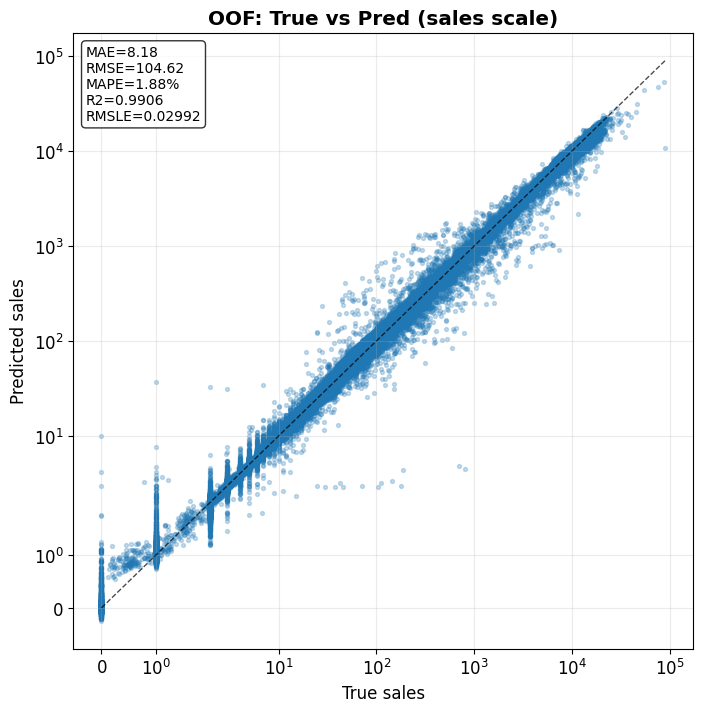

Saved: models\diag_residuals_hist_box.png


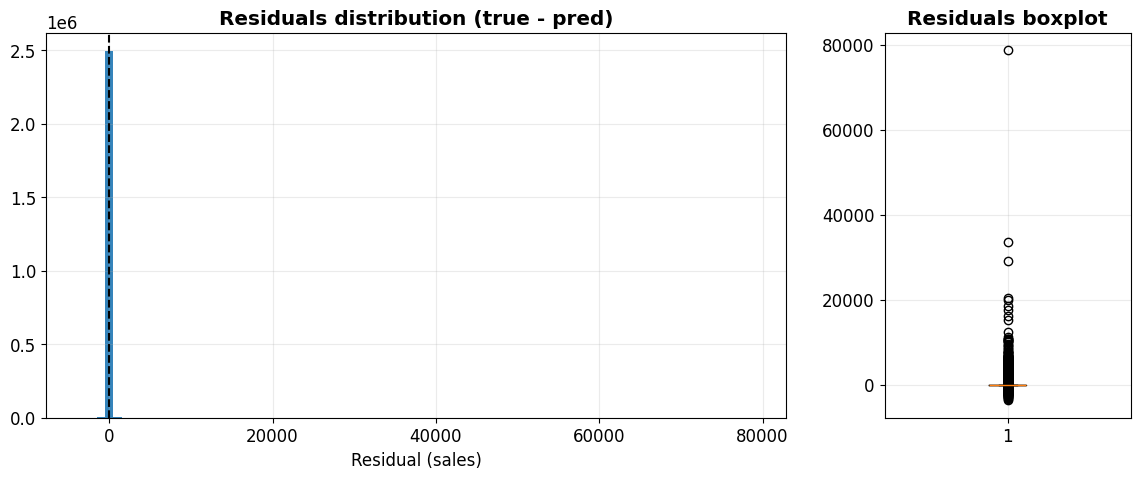

Saved: models\diag_residuals_vs_true.png


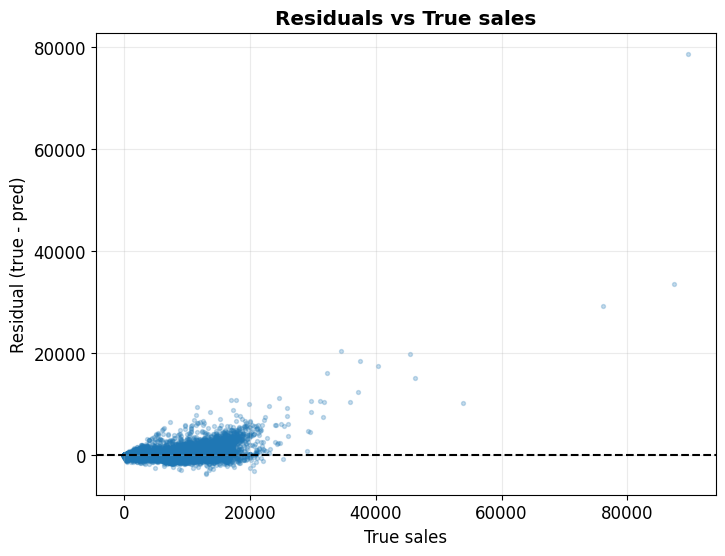


Top 30 absolute errors (OOF rows)
    true_sales    pred_sales       abs_err
1    89576.360  10845.909865  78730.450135
2    87438.516  53879.587157  33558.928843
3    76090.000  46852.444914  29237.555086
4    34454.000  14088.007706  20365.992294
5    45361.000  25469.691038  19891.308962
6    37514.926  19004.791133  18510.134867
7    40351.460  22852.106666  17499.353334
8    32209.000  16042.969127  16166.030873
9    46271.000  31053.327872  15217.672128
10   37106.000  24611.379558  12494.620442
11   24612.000  13398.026270  11213.973730
12   17850.615   6945.253692  10905.361308
13   17056.812   6183.451191  10873.360809
14   31125.521  20432.452499  10693.068501
15   29666.000  19107.020096  10558.979904
16   35828.000  25412.017334  10415.982666
17   31851.158  21436.163718  10414.994282
18   53874.000  43601.506281  10272.493719
19   19849.000   9729.973574  10119.026426
20   22978.000  13385.139160   9592.860840
21   11609.557   2183.311423   9426.245577
22   25852.000  166

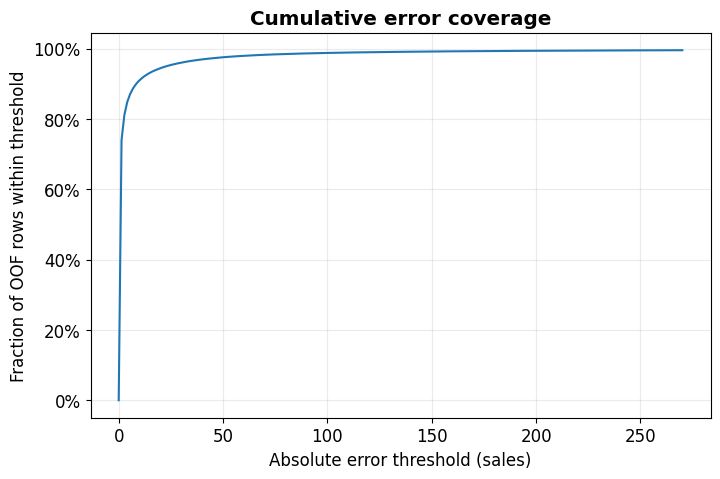


Found fold models: [WindowsPath('models/xgb_fold_1.json'), WindowsPath('models/xgb_fold_2.json'), WindowsPath('models/xgb_fold_3.json'), WindowsPath('models/xgb_fold_4.json'), WindowsPath('models/xgb_fold_5.json')]
Saved: models\diag_feature_importance_mean_gain.png


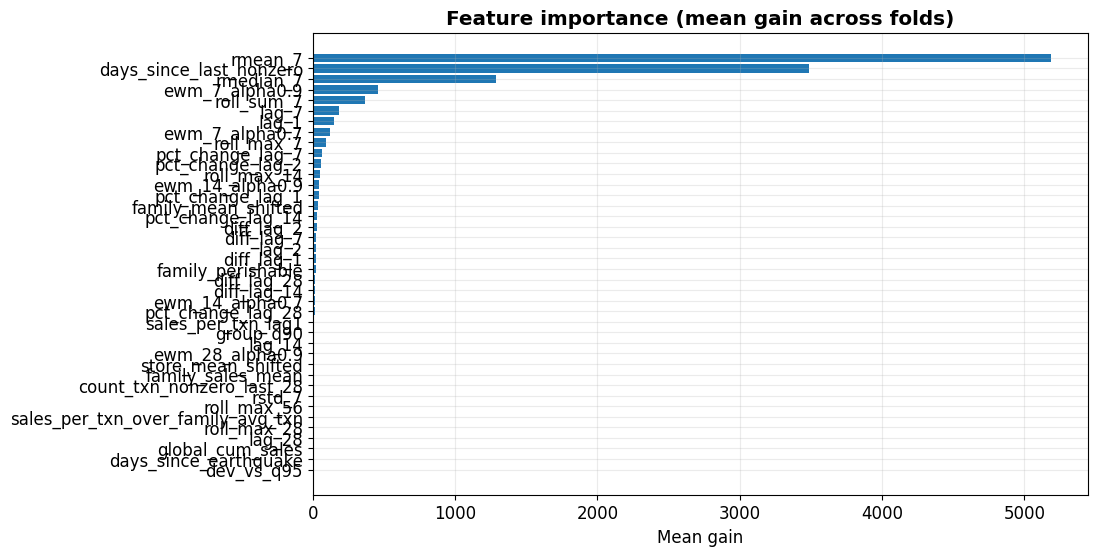


Loaded selected features count: 20
Sample features: ['rmean_7', 'days_since_last_nonzero', 'rmedian_7', 'ewm_7_alpha0.9', 'roll_sum_7', 'lag_7', 'lag_1', 'ewm_7_alpha0.7', 'roll_max_7', 'pct_change_lag_7', 'pct_change_lag_2', 'roll_max_14', 'ewm_14_alpha0.9', 'pct_change_lag_1', 'family_mean_shifted', 'pct_change_lag_14', 'diff_lag_2', 'diff_lag_7', 'lag_2', 'diff_lag_1']

No train_fe.pkl found in models/. If you want per-(store,family) time-series plots, save train_fe (the feature-engineered train frame) to models/train_fe.pkl and re-run this script.

All diagnostics complete. Check the saved PNGs in models/ and CSVs in models/.


In [ ]:

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import xgboost as xgb
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

OUT_DIR = Path("models")
DIAG_DIR = OUT_DIR / "diag"

def inv_target_transform(x):
    return np.expm1(x)

def rmsle_from_sales(y_true, y_pred):
    y_true = np.clip(np.array(y_true, dtype=float), 0, None)
    y_pred = np.clip(np.array(y_pred, dtype=float), 0, None)
    return float(np.sqrt(((np.log1p(y_pred) - np.log1p(y_true))**2).mean()))

def safe_metrics(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    nonzero = y_true != 0
    mape = (np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])).mean() * 100 if nonzero.sum() > 0 else np.nan
    try:
        r2 = r2_score(y_true, y_pred)
    except Exception:
        r2 = np.nan
    return dict(MAE=float(mae), RMSE=float(rmse), MAPE=float(mape), R2=float(r2))

if not OUT_DIR.exists():
    raise SystemExit(f"Can't find {OUT_DIR}. Run the training script first or point OUT_DIR to your models folder.")

oof_path = OUT_DIR / "oof_preds_log.npy"
ylog_path = OUT_DIR / "y_log.npy"
feats_path = OUT_DIR / "feats_selected.pkl"

if not oof_path.exists() or not ylog_path.exists():
    raise SystemExit("Missing oof_preds_log.npy or y_log.npy in models/. Make sure they exist.")

oof_preds_log = np.load(oof_path)
y_log = np.load(ylog_path)

mask_valid = ~np.isnan(oof_preds_log)
if mask_valid.sum() == 0:
    raise SystemExit("No valid OOF predictions found (all NaN). Check CV run.")

preds_log = oof_preds_log[mask_valid]
true_log = y_log[mask_valid]

preds_sales = inv_target_transform(preds_log)
true_sales = inv_target_transform(true_log)

metrics = safe_metrics(true_sales, preds_sales)
rmsle = rmsle_from_sales(true_sales, preds_sales)
print("OOF coverage rows:", mask_valid.sum(), "/", len(oof_preds_log))
print("OOF metrics (sales scale):", metrics)
print("OOF RMSLE (sales scale):", rmsle)

plt.rcParams.update({
    'figure.figsize': (10,6),
    'axes.grid': True,
    'grid.alpha': 0.25,
    'axes.titleweight': 'bold',
    'font.size': 12 })

def savefig(fig, name):
    out = OUT_DIR / f"diag_{name}.png"
    fig.savefig(out, bbox_inches='tight', dpi=150)
    print("Saved:", out)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(true_sales, preds_sales, s=8, alpha=0.25)
maxv = max(true_sales.max(), preds_sales.max())
ax.plot([0, maxv], [0, maxv], linestyle='--', linewidth=1, color='black', alpha=0.7)
ax.set_xlabel('True sales')
ax.set_ylabel('Predicted sales')
ax.set_title('OOF: True vs Pred (sales scale)')
ax.set_xscale('symlog' if true_sales.max() > 1e4 else 'linear')
ax.set_yscale('symlog' if preds_sales.max() > 1e4 else 'linear')
text = f"MAE={metrics['MAE']:.2f}\nRMSE={metrics['RMSE']:.2f}\nMAPE={metrics['MAPE']:.2f}%\nR2={metrics['R2']:.4f}\nRMSLE={rmsle:.5f}"
ax.text(0.02, 0.98, text, transform=ax.transAxes, fontsize=10, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
savefig(fig, 'scatter_true_vs_pred')
plt.show()

resid = true_sales - preds_sales
fig, axes = plt.subplots(1,2, figsize=(14,5), gridspec_kw={'width_ratios':[3,1]})
axes[0].hist(resid, bins=80, alpha=0.9)
axes[0].set_title('Residuals distribution (true - pred)')
axes[0].set_xlabel('Residual (sales)')
axes[0].axvline(0, color='black', linestyle='--')
axes[1].boxplot(resid, vert=True, showfliers=True)
axes[1].set_title('Residuals boxplot')
savefig(fig, 'residuals_hist_box')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(true_sales, resid, s=8, alpha=0.25)
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel('True sales')
ax.set_ylabel('Residual (true - pred)')
ax.set_title('Residuals vs True sales')
savefig(fig, 'residuals_vs_true')
plt.show()

abs_err = np.abs(resid)
idx_top = np.argsort(-abs_err)[:30]
summary_top = pd.DataFrame({
    'true_sales': true_sales[idx_top],
    'pred_sales': preds_sales[idx_top],
    'abs_err': abs_err[idx_top] })
summary_top.index = np.arange(1, len(summary_top)+1)
print('\nTop 30 absolute errors (OOF rows)')
print(summary_top.head(30).to_string())

summary_top.to_csv(OUT_DIR / 'diag_top_abs_errors.csv', index_label='rank')
print('Saved top abs errors CSV to models/diag_top_abs_errors.csv')

fig, ax = plt.subplots(figsize=(8,5))
thresholds = np.linspace(0, np.percentile(abs_err, 99.5)*1.1, 200)
coverage = [(abs_err <= t).mean() for t in thresholds]
ax.plot(thresholds, coverage)
ax.set_xlabel('Absolute error threshold (sales)')
ax.set_ylabel('Fraction of OOF rows within threshold')
ax.set_title('Cumulative error coverage')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
savefig(fig, 'cumulative_error_coverage')
plt.show()


fold_models = sorted(OUT_DIR.glob('xgb_fold_*.json'))
if fold_models:
    print('\nFound fold models:', fold_models)
    sum_gain = {}
    count_gain = {}
    for p in fold_models:
        try:
            b = xgb.Booster()
            b.load_model(str(p))
            fi = b.get_score(importance_type='gain')
            for f,g in fi.items():
                sum_gain[f] = sum_gain.get(f, 0.0) + g
                count_gain[f] = count_gain.get(f, 0) + 1
        except Exception as e:
            print('Warning loading', p, e)
    mean_gain = {f: sum_gain[f]/count_gain[f] for f in sum_gain.keys()} if sum_gain else {}
    sorted_feats = sorted(mean_gain.items(), key=lambda x: x[1], reverse=True)
    if sorted_feats:
        topk = min(40, len(sorted_feats))
        names = [f for f,g in sorted_feats[:topk]]
        vals = [g for f,g in sorted_feats[:topk]]
        fig, ax = plt.subplots(figsize=(10,6))
        ax.barh(range(len(names))[::-1], vals)
        ax.set_yticks(range(len(names))[::-1])
        ax.set_yticklabels(names)
        ax.set_title('Feature importance (mean gain across folds)')
        ax.set_xlabel('Mean gain')
        savefig(fig, 'feature_importance_mean_gain')
        plt.show()
    else:
        print('No feature importances extracted from fold models.')
else:
    print('No fold models found to compute importances (xgb_fold_*.json).')

if feats_path.exists():
    try:
        feats_selected = joblib.load(str(feats_path))
        print('\nLoaded selected features count:', len(feats_selected))
        print('Sample features:', feats_selected[:20])
    except Exception as e:
        print('Could not load feats_selected.pkl:', e)

train_fe_path = OUT_DIR / 'train_fe.pkl'
if train_fe_path.exists():
    try:
        print('\nLoading train_fe.pkl for time-series diagnostics...')
        train_fe = joblib.load(str(train_fe_path))
        if len(train_fe) != len(y_log):
            print('Warning: length mismatch between train_fe and y_log. Time-series plots may be misaligned.')
        train_fe = train_fe.reset_index(drop=True)
        train_fe['oof_pred_log'] = np.load(oof_path)
        train_fe['oof_pred_sales'] = inv_target_transform(train_fe['oof_pred_log'].fillna(np.nan))
        train_fe['true_sales'] = inv_target_transform(train_fe['sales_log'])

        grp = train_fe.groupby(['store_nbr','family']).size().sort_values(ascending=False)
        sample_keys = grp[grp >= 60].sample(n=min(6, grp[grp>=60].shape[0]), random_state=42).index.tolist()
        for i,(store,family) in enumerate(sample_keys, start=1):
            sub = train_fe[(train_fe['store_nbr']==store) & (train_fe['family']==family)].sort_values('date')
            fig, ax = plt.subplots(figsize=(12,4))
            ax.plot(sub['date'], sub['true_sales'], label='true', linewidth=1)
            ax.plot(sub['date'], sub['oof_pred_sales'], label='oof_pred', linewidth=1)
            ax.set_title(f'Store {store} - Family {family} (example #{i})')
            ax.legend()
            savefig(fig, f'timeseries_store{store}_fam_{family}')
            plt.show()
    except Exception as e:
        print('Failed to use train_fe.pkl for time-series plots:', e)
else:
    print('\nNo train_fe.pkl found in models/. If you want per-(store,family) time-series plots, save train_fe (the feature-engineered train frame) to models/train_fe.pkl and re-run this script.')

print('\nAll diagnostics complete. Check the saved PNGs in models/ and CSVs in models/.')


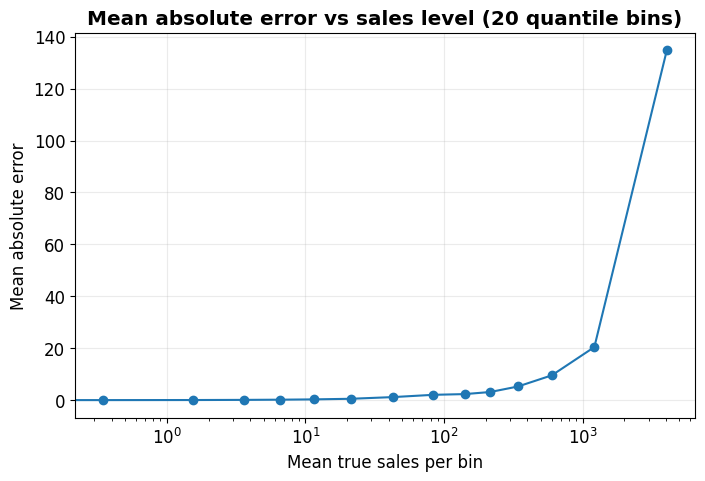

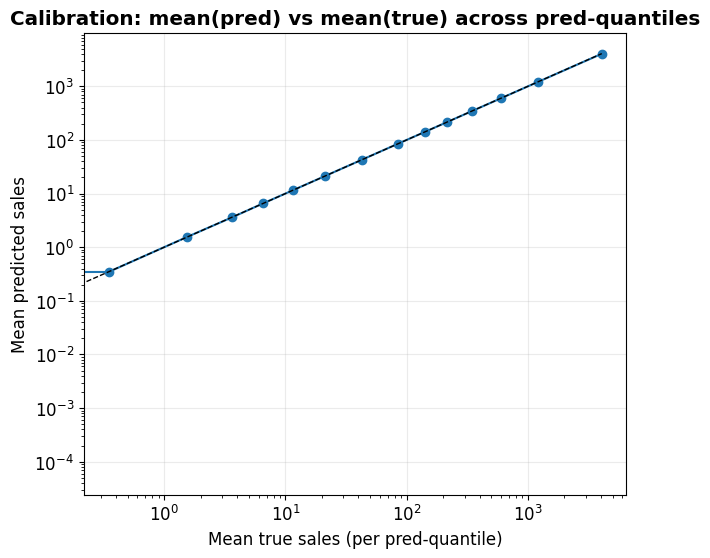

Saved top 200 absolute errors to models\diag_top_errors_200.csv
train_fe.pkl not found — skip per-family error.


In [6]:
# diagnostics_more.py
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

OUT = Path("models")
oof = np.load(OUT/"oof_preds_log.npy")
ylog = np.load(OUT/"y_log.npy")

mask = ~np.isnan(oof)
pred_log = oof[mask]; true_log = ylog[mask]
pred = np.expm1(pred_log); true = np.expm1(true_log)
resid = true - pred
abs_err = np.abs(resid)

# 1) خطأ متوسط حسب بنات المبيعات (sales bins)
df = pd.DataFrame({"true": true, "pred": pred, "resid": resid, "abs_err": abs_err})
df['sales_bin'] = pd.qcut(df['true'].rank(method='first'), q=20, labels=False)
grp = df.groupby('sales_bin').agg(
    n=('true','size'),
    mean_true=('true','mean'),
    mean_pred=('pred','mean'),
    mean_abs_err=('abs_err','mean'),
    median_abs_err=('abs_err','median')
).reset_index()

plt.figure(figsize=(8,5))
plt.plot(grp['mean_true'], grp['mean_abs_err'], marker='o')
plt.xscale('log' if grp['mean_true'].max()>1e3 else 'linear')
plt.yscale('log' if grp['mean_abs_err'].max()>1e3 else 'linear')
plt.xlabel('Mean true sales per bin')
plt.ylabel('Mean absolute error')
plt.title('Mean absolute error vs sales level (20 quantile bins)')
plt.grid(alpha=0.25)
plt.savefig(OUT/"diag_err_vs_sales_bin.png", dpi=150, bbox_inches='tight')
plt.show()

# 2) calibration by predicted-quantile (mean predicted vs mean true)
df['pred_q'] = pd.qcut(df['pred'].rank(method='first'), q=20, labels=False)
cal = df.groupby('pred_q').agg(mean_pred=('pred','mean'), mean_true=('true','mean')).reset_index()
plt.figure(figsize=(7,6))
plt.plot(cal['mean_true'], cal['mean_pred'], marker='o')
mx = max(cal['mean_true'].max(), cal['mean_pred'].max())
plt.plot([0,mx],[0,mx],'--', color='black', linewidth=1)
plt.xscale('log' if mx>1e3 else 'linear'); plt.yscale('log' if mx>1e3 else 'linear')
plt.xlabel('Mean true sales (per pred-quantile)')
plt.ylabel('Mean predicted sales')
plt.title('Calibration: mean(pred) vs mean(true) across pred-quantiles')
plt.grid(alpha=0.25)
plt.savefig(OUT/"diag_calibration_by_pred_quantile.png", dpi=150, bbox_inches='tight')
plt.show()

# 3) top errors CSV (already saved by script, but ensure)
top = df.sort_values('abs_err', ascending=False).head(200)
top[['true','pred','abs_err']].to_csv(OUT/"diag_top_errors_200.csv", index=False)
print("Saved top 200 absolute errors to", OUT/"diag_top_errors_200.csv")

# 4) إذا كان لديك train_fe.pkl يمكنك حساب خطأ متوسط per-family/per-store
train_fe_path = OUT/"train_fe.pkl"
if train_fe_path.exists():
    import joblib
    train_fe = joblib.load(train_fe_path).reset_index(drop=True)
    # align lengths
    if len(train_fe) == len(ylog):
        train_fe = train_fe[mask].reset_index(drop=True)
        train_fe['true'] = true
        train_fe['pred'] = pred
        train_fe['abs_err'] = abs_err
        fam_err = train_fe.groupby('family').agg(n=('true','size'), mean_abs_err=('abs_err','mean')).reset_index()
        fam_err.sort_values('mean_abs_err', ascending=False).head(20).to_csv(OUT/"diag_families_top20_by_abserr.csv", index=False)
        print("Saved family-level error summary to", OUT/"diag_families_top20_by_abserr.csv")
    else:
        print("Warning: train_fe length != y_log length, cannot align for per-family error.")
else:
    print("train_fe.pkl not found — skip per-family error.")
